In [1]:
import sys
print('sys')
sys.path.append("C:\\Users\\infinigru\\Anaconda3\\envs\\prac\\lib\\site-packages")
# sys.path = ["C:\\Users\\infinigru\\Anaconda3\\envs\\prac\\lib\\site-packages"] + sys.path
import os
print('os')
import numpy as np
import tensorflow as tf
print('tensorflow :',tf.__version__)
from sklearn.metrics import confusion_matrix

from config import *
from utils.util import *
from model import *
from iterator import batch_iterator

sys
os
tensorflow : 1.13.1


In [2]:
# with open(os.path.join(RESULT_PATH,"history.csv"),'w') as f:
#     f.write("epoch,loss,acc,val_loss,val_acc\n")
import pandas as pd
hist = pd.read_csv(os.path.join(RESULT_PATH,"history.csv"))

In [3]:
# history_graph(hist)

In [4]:
with tf.device('/device:GPU:0'):
    # placeholder for images
    shapes = list((None,)+IMAGE_SHAPE)
    images = tf.placeholder('float32', shape=shapes, name='images')  
    
    # placeholder for labels
    labels = tf.placeholder('float32', shape=[None, 1], name='labels')  
    
    # placeholder for training boolean (is training)
    training = tf.placeholder('bool', name='training') 
    ## placeholder fot store Beat accuracy
    best_accuracy = tf.get_variable(name='best_accuracy', dtype='float32', trainable=False, initializer=0.0)
#     best_auc = 0
    # model build
    with tf.variable_scope('build'):
        output = ResNetV2(training).build(images)

Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.average_pooling2d instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.


In [5]:
with tf.variable_scope('losses'):
    loss = tf.keras.backend.binary_crossentropy(labels, output)
    loss = tf.reduce_mean(loss, name='loss')

In [6]:
# check_point_epoch = 1
# restore_meta = os.path.join(RESULT_PATH,f"checkpoint_{check_point_epoch}.ckpt.meta")
# restore_meta

In [7]:
graph = tf.get_default_graph()

In [8]:
# saver = tf.train.import_meta_graph(restore_meta)

In [9]:
# for i in graph.get_operations():
#     if 'output-layer' in str(i):
#         print(i)

In [10]:
args = TrainOption()

In [11]:
with open(TEST_FILE.split('.')[0] + '.length', 'r') as f:
    test_data_lenth = int(f.read())
with open(TRAIN_FILE.split('.')[0] + '.length', 'r') as f:
    train_data_lenth = int(f.read())

In [81]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    saver = tf.train.Saver()
    saver.restore(sess, tf.train.latest_checkpoint(RESULT_PATH))
    
    print(f"test data from : {TEST_FILE}")
    test_iterator = batch_iterator(TEST_FILE , batch_size=args.BATCH_SIZE
                                   , training=False, shuffle=False, buffer_size=50)
    test_images_batch, test_labels_batch = test_iterator.get_next()
    
    sess.run(test_iterator.initializer)
    # get tensor for feed forward    
#     graph = tf.get_default_graph()
#     images = graph.get_tensor_by_name('images:0')
    
    val_loss = []
    val_acc = np.array([])

    y_pred = np.array([])
    y_target = np.array([])
    imgs = np.zeros((1,) + IMAGE_SHAPE)
        
    print('testing ...')
    pr=progress()
    i = 0
        
    print(""" Validation """)
    while True:
        i += 1
        pr.print_progress(args.BATCH_SIZE,test_data_lenth,' ')
        try:
            test_images, test_labels = sess.run([test_images_batch, test_labels_batch])
            loss_, output_= sess.run([loss, output]
                                     , feed_dict={images: test_images, labels: test_labels
                                   , training: False}) #tf.keras.backend.learning_phase():0
            
            ## losses
            val_loss.append(loss_)
#             print(y_pred)
            y_pred = np.append(y_pred , np.array(output_).flatten())
            y_target = np.append(y_target , np.array(test_labels).flatten())

            ## accuracy
            #equal = np.equal(np.argmax(output_,axis =1) , np.argmax(train_labels,axis =1))        
            for i in range(args.BATCH_SIZE):
                if float(output_[i]>0.5) != test_labels[i]:
                    testimg = test_images[i].reshape((1,)+IMAGE_SHAPE)
                    imgs = np.vstack([imgs,testimg])
                    
        except tf.errors.OutOfRangeError:
            sess.run(test_iterator.initializer)
            break
        
        imgs = imgs[1:]
#         if i> 50:
#             break
            
    sess.close()
# 출처: https://goodtogreate.tistory.com/entry/Saving-and-Restoring [GOOD to GREAT]

INFO:tensorflow:Restoring parameters from D:\Projects\my_Glaucoma_project\result\checkpoint_1.ckpt
test data from : D:\Projects\my_Glaucoma_project\dataset\Glaucoma\test.tfrecord
testing ...
 Validation 
 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]   Done

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(91, 256, 256, 3)


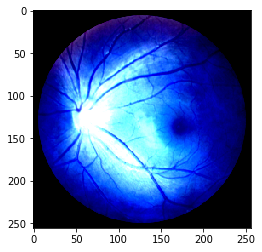

In [82]:
print(imgs.shape)
plt.imshow(imgs[0])

In [30]:
# print(test_images.shape)
# plt.imshow(imgs[0])
# test_images.shape

In [120]:
print_confusion_matrix(y_target, y_pred)

         1,    0
    1   34,  284
    0    6,   76
